# **Business Problem**
It is desired to develop a machine learning model that can predict whether people have diabetes when their characteristics are specified. You are expected to perform the necessary data analysis and feature engineering steps before developing the model.

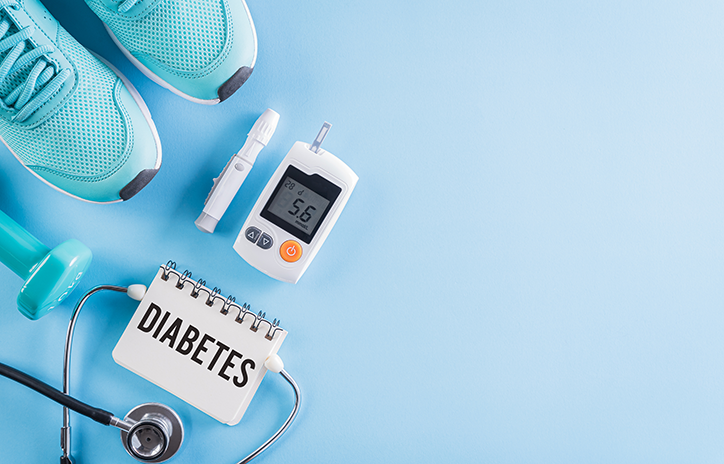

# **About Dataset**
The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases in the USA. Data used for diabetes research on Pima Indian women aged 21 and over living in Phoenix, the 5th largest city of the State of Arizona in the USA. The target variable is specified as "outcome"; 1 indicates positive diabetes test result, 0 indicates negative.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
pd.set_option("display.width", 500)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" %x)

def load():
    data = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
    return data
df = load()

# **Task 1 : EDA**

**Step 1:** Examine the general picture.

In [3]:
def general_picture(dataframe):
    print("Shape".center(70, "~"))
    print(dataframe.shape)
    print("Variables".center(70, "~"))
    print(dataframe.columns)
    print("NA".center(70, "~"))
    print(dataframe.isnull().sum())
    print("Head".center(70, "~"))
    print(dataframe.head())
    print("Describe".center(70, "~"))
    print(dataframe.describe().T)
general_picture(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Shape~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(768, 9)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Variables~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'], dtype='object')
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~NA~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Head~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29   

**Step 2:** Capture the numeric and categorical variables.

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cats = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cats
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cats]
    print(f"Observation: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_car: {len(num_but_cats)}")
    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observation: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_car: 1


**Step 3:** Analyze the numerical and categorical variables.

   Outcome  Ratio
0      500 65.104
1      268 34.896
###########################
Outcome : [1 0]
###########################


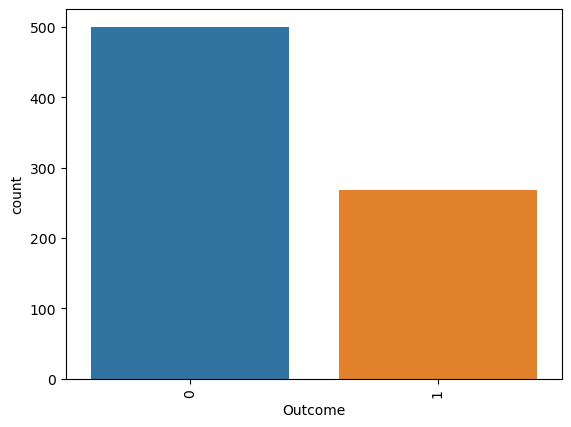

<Figure size 1400x1400 with 0 Axes>

In [5]:
def category_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("###########################")
    print(f"{col_name} : {dataframe[col_name].unique()}")
    print("###########################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe);
        plt.xticks(rotation=90);
        plt.figure(figsize=(14, 14));
        plt.show(block=True);


for col in cat_cols:
    if df[col].dtypes == "bool":
        df[col] = df[col].astype(int)
        category_summary(df, col, plot=True);
    else:
        category_summary(df, col, plot=True);

count   768.000
mean      3.845
std       3.370
min       0.000
0%        0.000
5%        0.000
50%       3.000
95%      10.000
99%      13.000
100%     17.000
max      17.000
Name: Pregnancies, dtype: float64


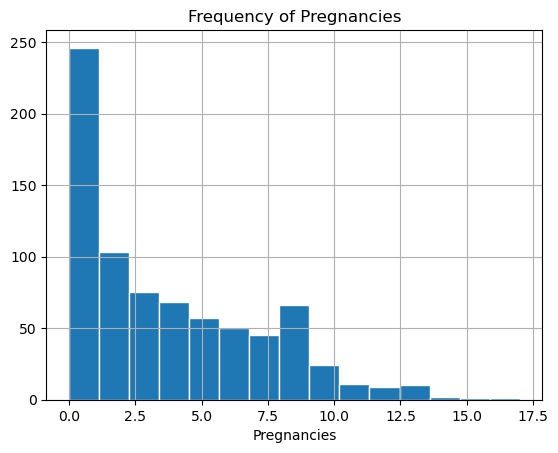

count   768.000
mean    120.895
std      31.973
min       0.000
0%        0.000
5%       79.000
50%     117.000
95%     181.000
99%     196.000
100%    199.000
max     199.000
Name: Glucose, dtype: float64


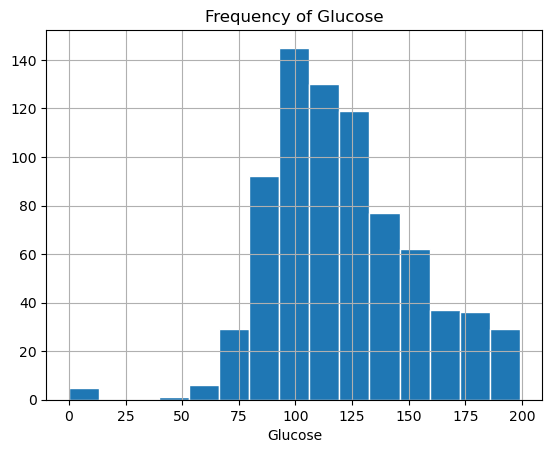

count   768.000
mean     69.105
std      19.356
min       0.000
0%        0.000
5%       38.700
50%      72.000
95%      90.000
99%     106.000
100%    122.000
max     122.000
Name: BloodPressure, dtype: float64


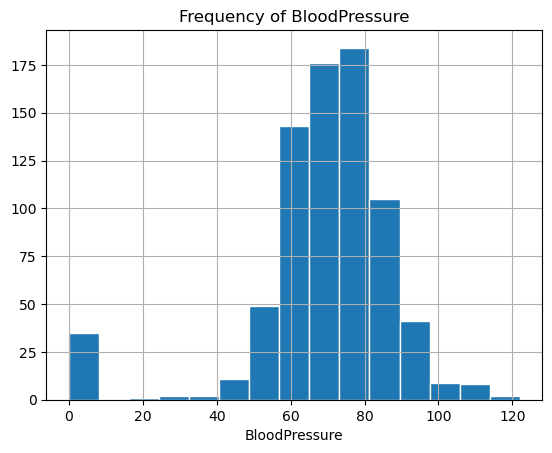

count   768.000
mean     20.536
std      15.952
min       0.000
0%        0.000
5%        0.000
50%      23.000
95%      44.000
99%      51.330
100%     99.000
max      99.000
Name: SkinThickness, dtype: float64


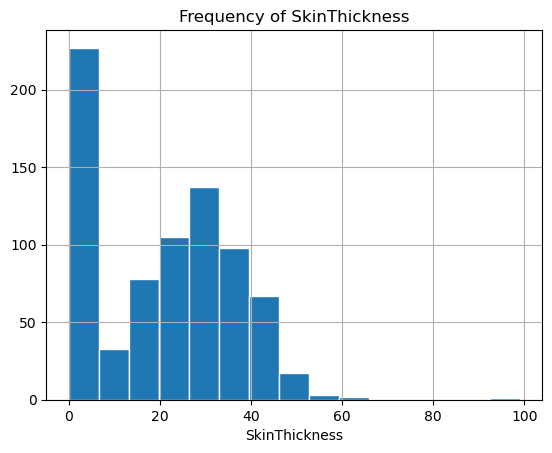

count   768.000
mean     79.799
std     115.244
min       0.000
0%        0.000
5%        0.000
50%      30.500
95%     293.000
99%     519.900
100%    846.000
max     846.000
Name: Insulin, dtype: float64


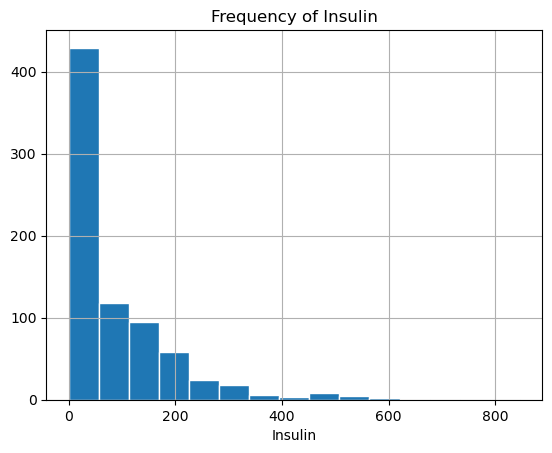

count   768.000
mean     31.993
std       7.884
min       0.000
0%        0.000
5%       21.800
50%      32.000
95%      44.395
99%      50.759
100%     67.100
max      67.100
Name: BMI, dtype: float64


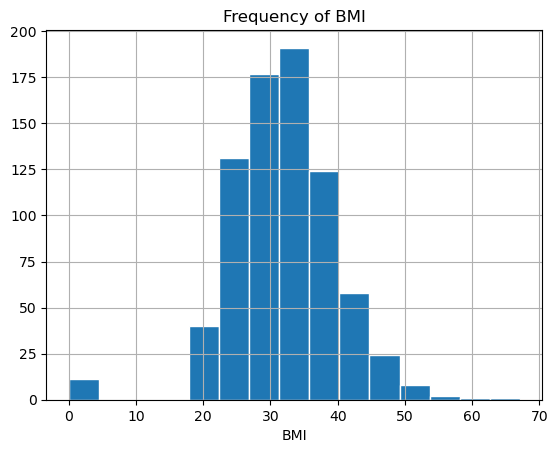

count   768.000
mean      0.472
std       0.331
min       0.078
0%        0.078
5%        0.140
50%       0.372
95%       1.133
99%       1.698
100%      2.420
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


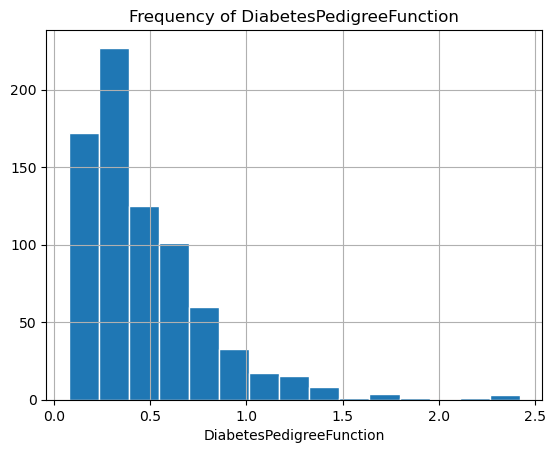

count   768.000
mean     33.241
std      11.760
min      21.000
0%       21.000
5%       21.000
50%      29.000
95%      58.000
99%      67.000
100%     81.000
max      81.000
Name: Age, dtype: float64


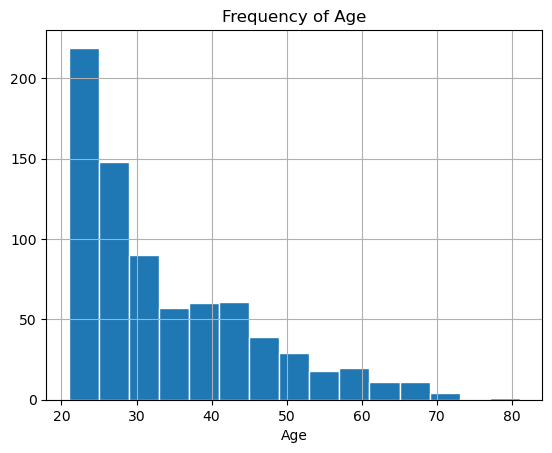

In [6]:
def number_summary(dataframe, numberical_col, plot=False):
    quantiles = [0, 0.05, 0.95, 0.99, 1]
    print(dataframe[numberical_col].describe(quantiles).T)
    if plot:
        dataframe[numberical_col].hist(bins=15,ec='white')
        plt.xlabel(numberical_col)
        plt.title(f"Frequency of {numberical_col}")
        plt.show(block=True)

for col in num_cols:
    number_summary(df, col, plot=True)

**Step 4:** Perform target variable analysis. (The mean of the target variable according to the categorical variables, mean of numerical variables relative to the target variable)

In [7]:
def target_summary_with_cat(dataframe, target, categorical_col):
    if target==categorical_col:
        print("no")
    else:
        print(pd.DataFrame({"Target_Mean": dataframe.groupby(categorical_col)[target].mean()}))

for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col)

def target_summary_with_num(dataframe, target, numerical_col):
    if target==numerical_col:
        print("no")
    else:
        print(pd.DataFrame({"Target_Mean": dataframe.groupby(numerical_col)[target].mean()}))

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

no
             Target_Mean
Pregnancies             
0                  0.342
1                  0.215
2                  0.184
3                  0.360
4                  0.338
5                  0.368
6                  0.320
7                  0.556
8                  0.579
9                  0.643
10                 0.417
11                 0.636
12                 0.444
13                 0.500
14                 1.000
15                 1.000
17                 1.000
         Target_Mean
Glucose             
0              0.400
44             0.000
56             0.000
57             0.000
61             0.000
62             0.000
65             0.000
67             0.000
68             0.000
71             0.000
72             0.000
73             0.000
74             0.000
75             0.000
76             0.000
77             0.000
78             0.250
79             0.000
80             0.167
81             0.000
82             0.000
83             0.000
84             0.1

**Step 5:** Perform outlier analysis.

In [8]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    # catch outliers
    q1 = dataframe[col_name].quantile(q1)
    q3 = dataframe[col_name].quantile(q3)
    interquartile_range = q3 - q1
    up_limit = q3 + 1.5 * interquartile_range
    low_limit = q1 - 1.5 * interquartile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
   # check if there is an outlier during the code flow. If there is, it gives direction when we want to do a task or when we want to do a task.
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


**Step 6:** Perform missing observation analysis.

In [9]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
df.head()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


**As can be seen here, other variables other than Pregnancies and Outcome cannot be 0 in terms of health if the minimum value if it is zero, it means that there is a  missing value, then we will catch the zero value and write NaN instead.**

In [11]:
zero_col = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
for col in zero_col:
    df[col] = df[col].replace(0, np.nan)
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum()]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
na_cols = missing_values_table(df)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


<AxesSubplot:>

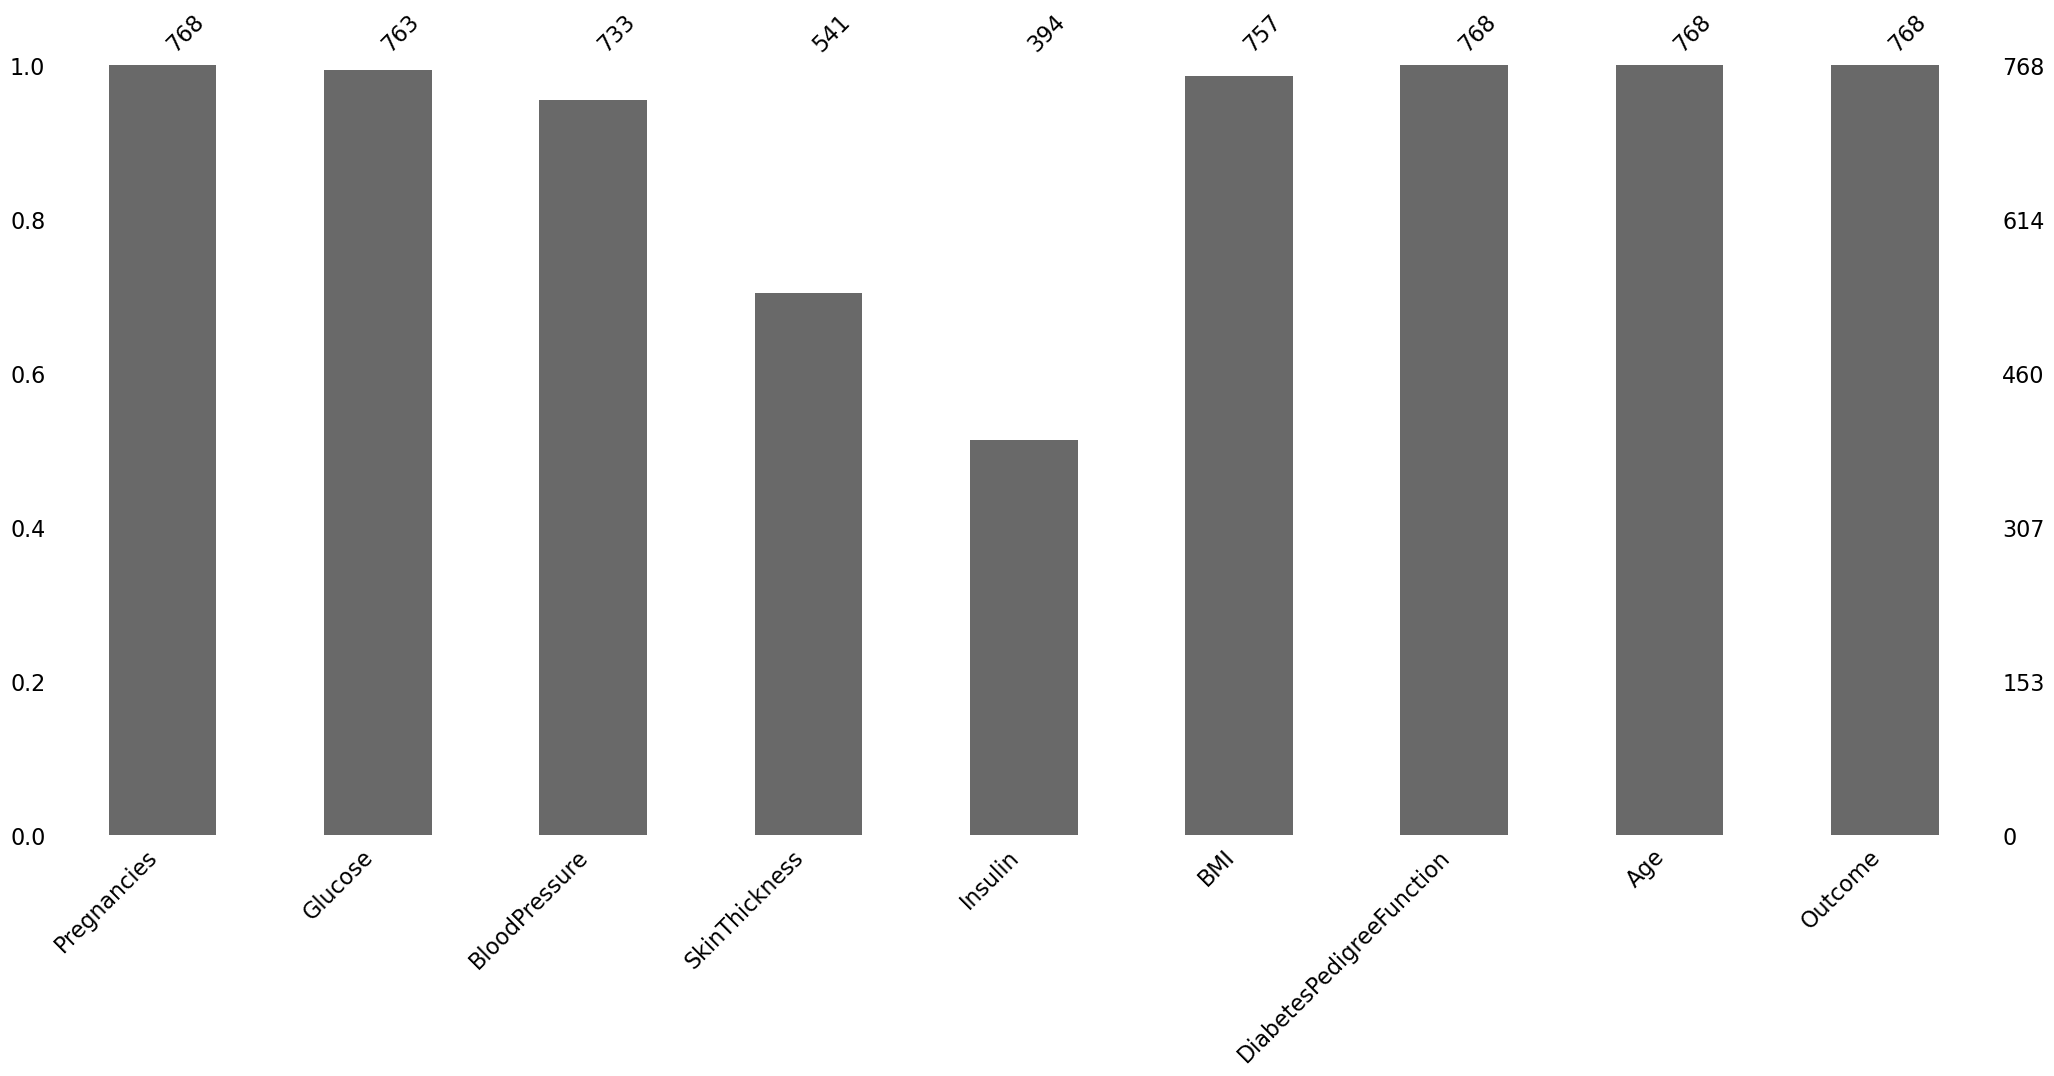

In [12]:
msno.bar(df)

<AxesSubplot:>

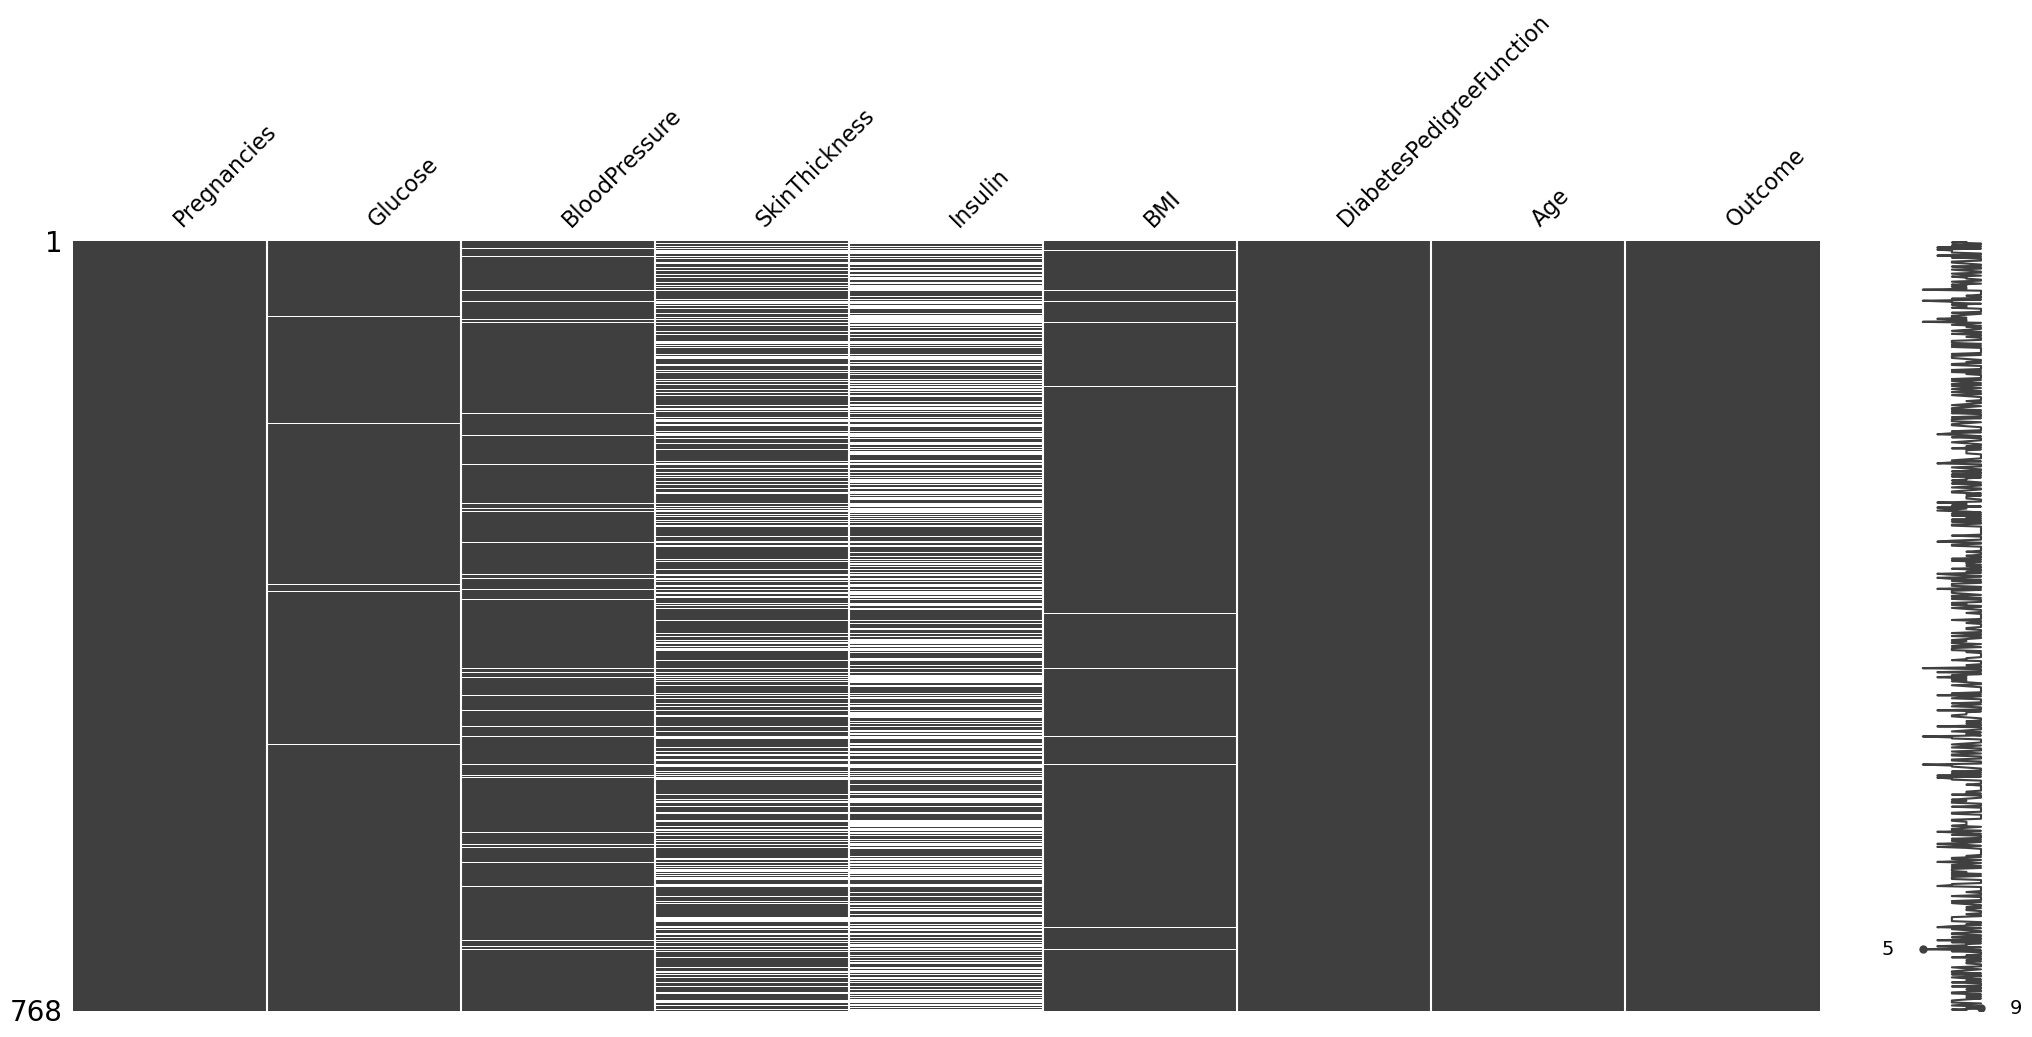

In [13]:
msno.matrix(df)

<AxesSubplot:>

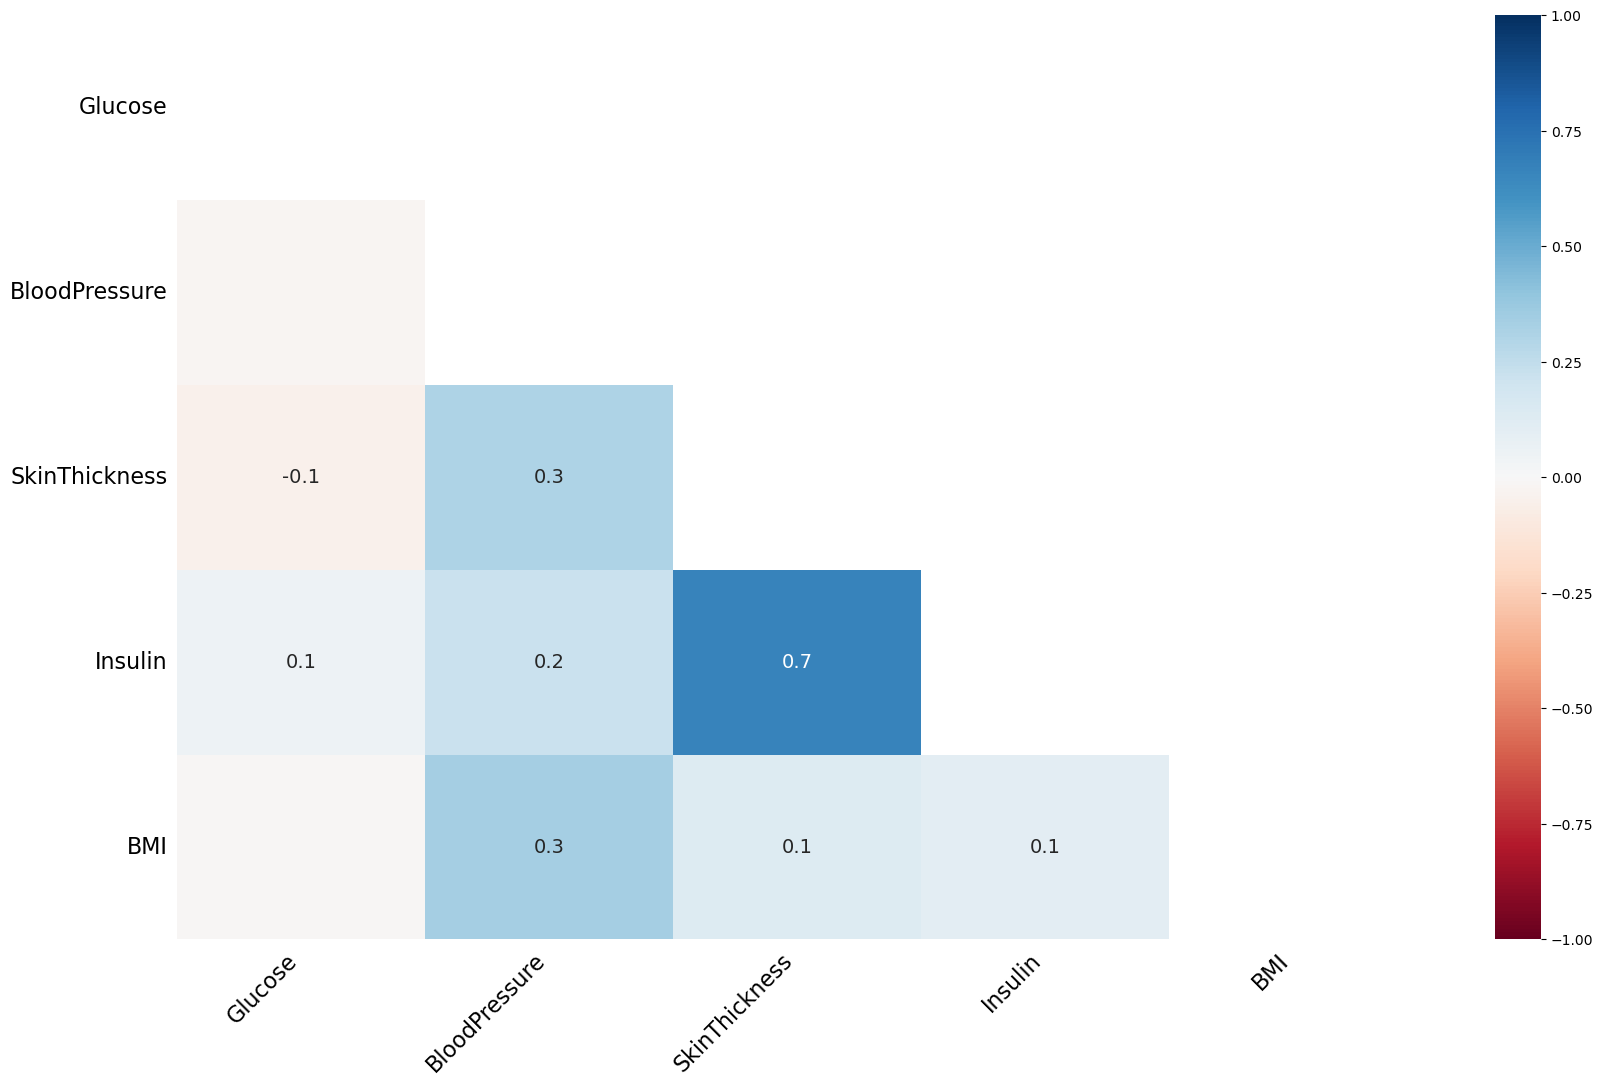

In [14]:
msno.heatmap(df)

**Step 7:** Perform correlation analysis.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


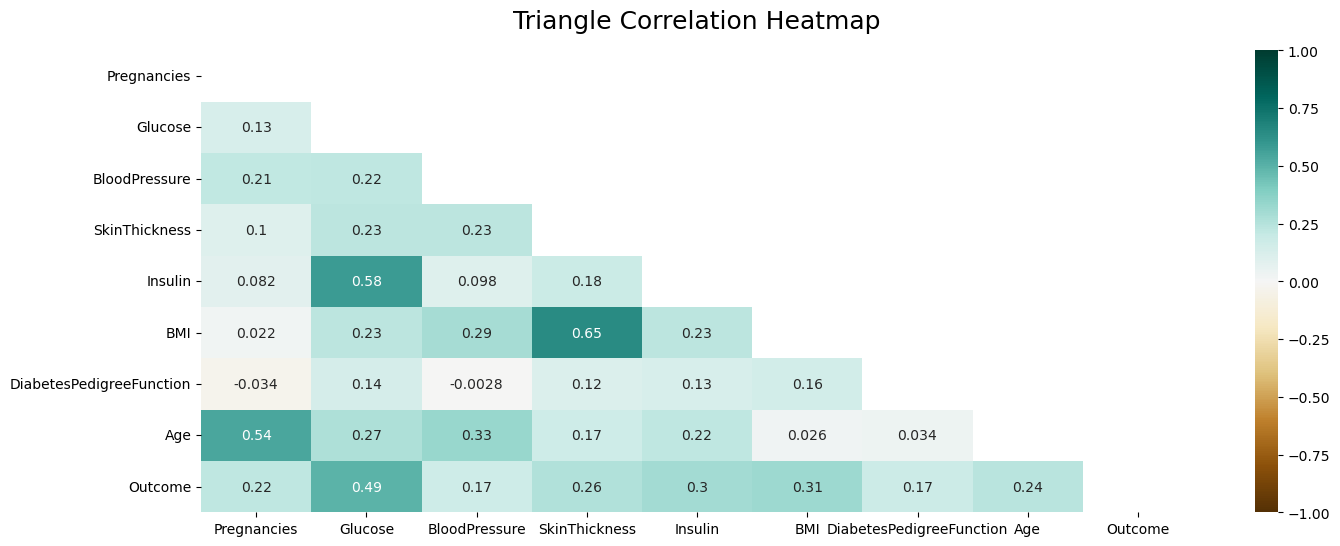

In [15]:
df.corr()
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

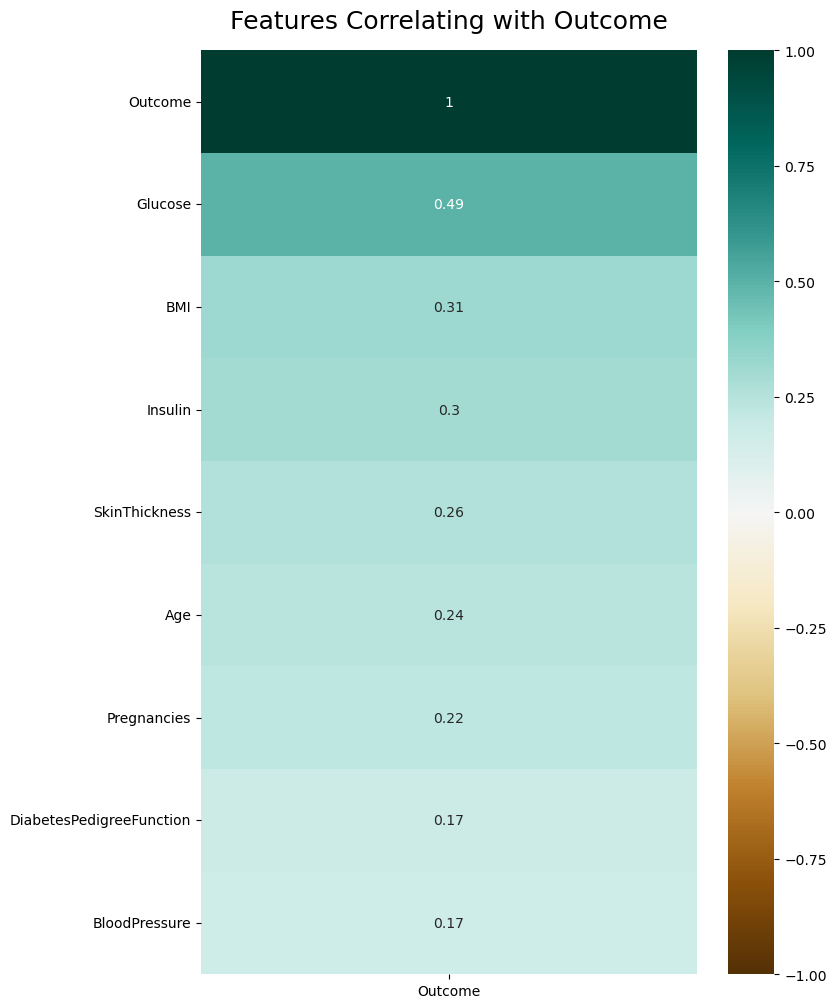

In [16]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Outcome']].sort_values(by='Outcome', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Outcome', fontdict={'fontsize':18}, pad=16);

# **Task 2 : Feature Engineering**

**Step 1:** Take necessary actions for missing and outlier values.

In [17]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)

In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dff = imputer.fit_transform(dff)
df = pd.DataFrame(scaler.inverse_transform(dff), columns=df.columns)

Observation: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_car: 1


**Step 2:** Feature Extraction.

In [19]:
# age interval
df.loc[(df["Age"] >= 21) & (df["Age"] < 29), "age_interval"] = "young"
df.loc[(df["Age"] >= 29) & (df["Age"] < 41), "age_interval"] = "adult"
df.loc[(df["Age"] >= 41) & (df["Age"] <= 81), "age_interval"] = "old"

In [20]:
# BMI
df["bmi_cat"] = pd.cut(x=df["BMI"], bins=(0, 18.5, 24.9, 29.9, 34.9, 39.9, 100), labels=("thin", "normal", "fat", "type 1 obese", "type 2 obese", "type 3 obese"))

In [21]:
# Pregnancies
df.loc[(df["Pregnancies"] <= 1), "Pregnancies_num"] = "less"
df.loc[(df["Pregnancies"] > 1) & (df["Pregnancies"] <= 3), "Pregnancies_num"] = "normal"
df.loc[(df["Pregnancies"] > 3) & (df["Pregnancies"] <= 6), "Pregnancies_num"] = "high"
df.loc[(df["Pregnancies"] > 6) & (df["Pregnancies"] <= 20), "Pregnancies_num"] = "abnormal"

In [22]:
df.loc[(df["Pregnancies"] > 0), "Pregnancies_sit"] = "YES"
df.loc[(df["Pregnancies"] == 0), "Pregnancies_sit"] = "NO"

In [23]:
# Glucose
df.loc[(df["Glucose"] < 70), "Glucose_sit"] = "low"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 110)), "Glucose_sit"] = "normal"
df.loc[(df["Glucose"] >= 110), "Glucose_sit"] = "abnormal"

In [24]:
# Glucose and Insulin
df["glucose-insulin"] = df["Glucose"] * df["Insulin"]
df["skinthickness-insulin"] = df["SkinThickness"] * df["Insulin"]

In [25]:
# Age, BMI, Insulin
df.loc[((df["Age"] <= 21) & (df["Age"] < 30)) & (df["BMI"] <= 32) & (df["Insulin"] <= 100), "risk"] = "a"
df.loc[((df["Age"] <= 30) & (df["Age"] < 50)) & (df["BMI"] <= 32) & (df["Insulin"] <= 100), "risk"] = "b"
df.loc[((df["Age"] <= 50) & (df["Age"] <= 81)) & (df["BMI"] <= 32) & (df["Insulin"] <= 100), "risk"] = "c"
df.loc[((df["Age"] <= 21) & (df["Age"] < 30)) & (df["BMI"] > 32) & (df["Insulin"] <= 100), "risk"] = "d"
df.loc[((df["Age"] <= 30) & (df["Age"] < 50)) & (df["BMI"] > 32) & (df["Insulin"] <= 100), "risk"] = "e"
df.loc[((df["Age"] <= 50) & (df["Age"] <= 81)) & (df["BMI"] > 32) & (df["Insulin"] <= 100), "risk"] = "f"
df.loc[((df["Age"] <= 21) & (df["Age"] < 30)) & (df["BMI"] <= 32) & (df["Insulin"] > 100), "risk"] = "g"
df.loc[((df["Age"] <= 30) & (df["Age"] < 50)) & (df["BMI"] <= 32) & (df["Insulin"] > 100), "risk"] = "h"
df.loc[((df["Age"] <= 50) & (df["Age"] <= 81)) & (df["BMI"] <= 32) & (df["Insulin"] > 100), "risk"] = "j"
df.loc[((df["Age"] <= 21) & (df["Age"] < 30)) & (df["BMI"] > 32) & (df["Insulin"] > 100), "risk"] = "k"
df.loc[((df["Age"] <= 30) & (df["Age"] < 50)) & (df["BMI"] > 32) & (df["Insulin"] > 100), "risk"] = "l"
df.loc[((df["Age"] <= 50) & (df["Age"] <= 81)) & (df["BMI"] > 32) & (df["Insulin"] > 100), "risk"] = "m"

In [26]:
df.columns = [col.upper() for col in df.columns]
cat_cols, num_cols, cat_but_car = grab_col_names(df)
for col in num_cols:
    print(col, check_outlier(df, col))
for col in num_cols:
    replace_with_thresholds(df, col)

Observation: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_car: 2
PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS True
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False
GLUCOSE-INSULIN True
SKINTHICKNESS-INSULIN True


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:10531: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'bool_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return NDFrame.any(self, axis, bool_only, skipna, level, **kwargs)


**Step3:** Encoding Scaling

In [27]:
def label_encoder(dataframe, binary_col):
    le = LabelEncoder()
    dataframe[binary_col] = le.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

In [28]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "OUTCOME", cat_cols)

AGE_INTERVAL : 3
       COUNT  RATIO  TARGET_MEAN
adult    207  0.270        0.459
old      194  0.253        0.526
young    367  0.478        0.193


PREGNANCIES_NUM : 4
          COUNT  RATIO  TARGET_MEAN
abnormal    169  0.220        0.562
high        175  0.228        0.343
less        246  0.320        0.272
normal      178  0.232        0.258


PREGNANCIES_SIT : 2
   COUNT  RATIO  TARGET_MEAN
0    111  0.145        0.342
1    657  0.855        0.350


GLUCOSE_SIT : 3
          COUNT  RATIO  TARGET_MEAN
abnormal    456  0.594        0.496
low          11  0.014        0.000
normal      301  0.392        0.140


RISK : 4
   COUNT  RATIO  TARGET_MEAN
c    158  0.206        0.038
f     77  0.100        0.169
j    182  0.237        0.368
m    270  0.352        0.533


OUTCOME : 2
       COUNT  RATIO  TARGET_MEAN
0.000    500  0.651        0.000
1.000    268  0.349        1.000


BMI_CAT : 6
              COUNT  RATIO  TARGET_MEAN
thin              4  0.005        0.000
normal         

In [29]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy() # A copy of the dataframe has been created.

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == "O" and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    # Variables with rare value selected.

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df) # We select the relevant variable from the tem_df dataframe. We take the value_counts and divide by the number of observations. We create a new dataframe named tmp.
        rare_labels = tmp[tmp < rare_perc].index # Assign the index of values that are below the rare_perc rate we set in this dataframe to rare_labels.
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var]) # If you have these rare_labels (isin) in the main dataframe, assign "Rare" to where it is (where) otherwise leave it as it is.

    return temp_df

df = rare_encoder(df, 0.01)
rare_analyser(df, "OUTCOME", cat_cols)

AGE_INTERVAL : 3
       COUNT  RATIO  TARGET_MEAN
adult    207  0.270        0.459
old      194  0.253        0.526
young    367  0.478        0.193


PREGNANCIES_NUM : 4
          COUNT  RATIO  TARGET_MEAN
abnormal    169  0.220        0.562
high        175  0.228        0.343
less        246  0.320        0.272
normal      178  0.232        0.258


PREGNANCIES_SIT : 2
   COUNT  RATIO  TARGET_MEAN
0    111  0.145        0.342
1    657  0.855        0.350


GLUCOSE_SIT : 3
          COUNT  RATIO  TARGET_MEAN
abnormal    456  0.594        0.496
low          11  0.014        0.000
normal      301  0.392        0.140


RISK : 4
   COUNT  RATIO  TARGET_MEAN
c    158  0.206        0.038
f     77  0.100        0.169
j    182  0.237        0.368
m    270  0.352        0.533


OUTCOME : 2
       COUNT  RATIO  TARGET_MEAN
0.000    500  0.651        0.000
1.000    268  0.349        1.000


BMI_CAT : 6
              COUNT  RATIO  TARGET_MEAN
thin              4  0.005        0.000
normal         

In [30]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
df = one_hot_encoder(df, cat_cols, drop_first=True)

**Step 4:** Standardize for numeric variables.

In [31]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

**Step 5:** Build model.

In [32]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7878787878787878

**Step 6:** Show the effect of the variables on the model.

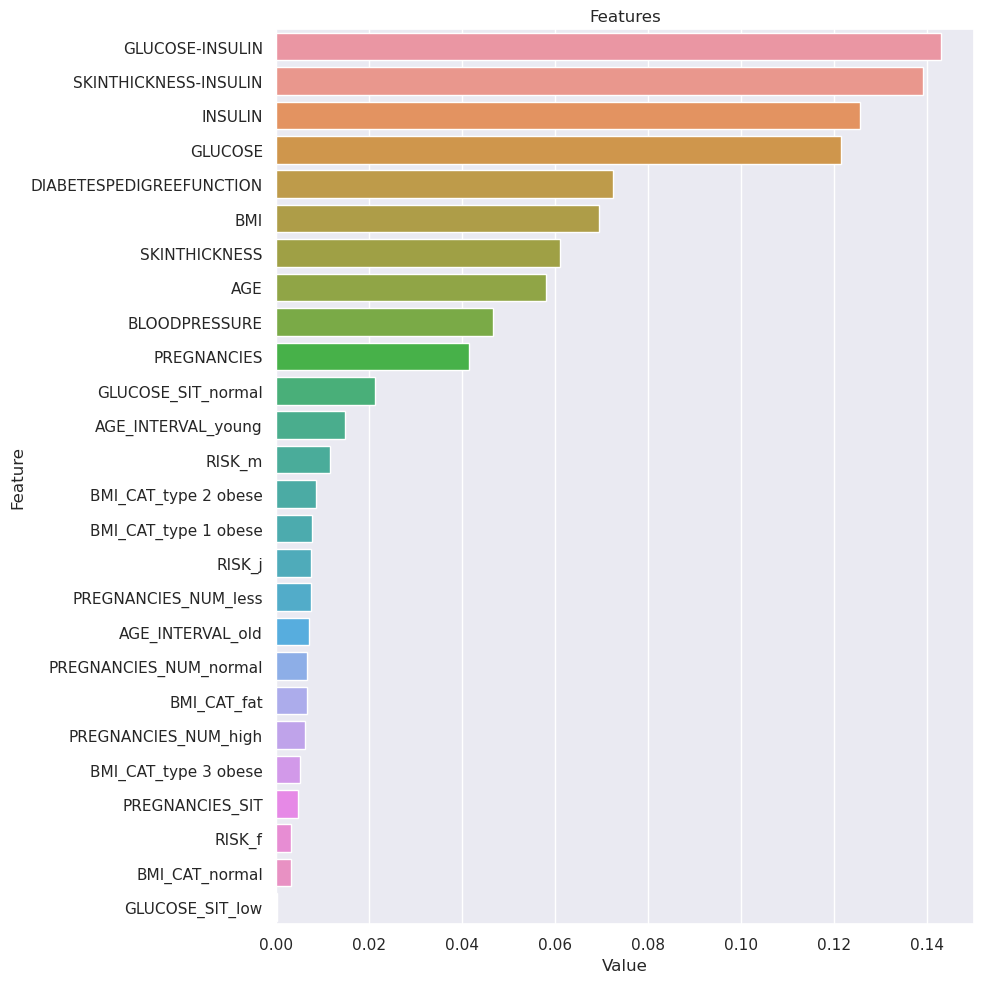

In [33]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    if save:
        plt.savefig("importances.png")
plot_importance(rf_model, X_train)